## Week 6 - Deformable models 

In [4]:
import imageio
from imageio import get_reader
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage.draw as draw

In [5]:
mov = get_reader("week_6/data/crawling_amoeba.mov")

In [6]:
# parameters
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 1
beta = 1

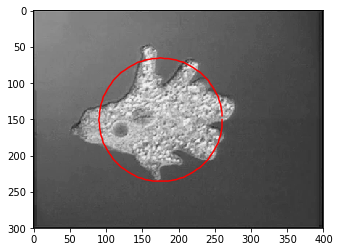

In [8]:
# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve

plt.plot(snake[:,0], snake[:,1], color = 'red')
plt.imshow(frames[0], cmap="gray")
plt.show()

In [10]:
mask = draw.polygon2mask(frames[0].shape, snake)

def m1m2(frame, snake, mask):
    c_in, c_out=0, 0
    m_in, m_out=0, 0
    x, y=frame.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j]:
                m_in=((c_in)/(c_in+1))*m_in + 1/(c_in+1)*frame[i,j]
                c_in+=1
            else:
                m_out=((c_out)/(c_out+1))*m_out + 1/(c_out+1)*frame[i,j]
                c_out+=1
    return m_in, m_out, c_in, c_out

m_in, m_out, c_in, c_out = m1m2(frames[0], snake, mask)
print(m_in, m_out)

0.5503292801219387 0.3462047867626851


In [11]:
def forceImage_ext(frame, snake, m_in, m_out):
    z = np.array(list(map(lambda x: frame[int(x[0]), int(x[1])], snake)))
    f_ext = (m_in-m_out)*(z-0.5*(m_in+m_out))
    return f_ext
z = forceImage_ext(frames[0], snake, m_in, m_out)

In [12]:
def snakeNormals(snake):
    N = np.zeros((len(snake), 2))
    diff = snake[1,:]-snake[-1,:]
    N[0,:] = [diff[1], -diff[0]]
    for i in range(len(snake)-2):
        k=i+1
        diff = snake[k+1,:]-snake[k-1]
        N[k,:] = [diff[1], -diff[0]]
    diff = snake[0,:]-snake[-2,:]
    N[-1,:] = [diff[1], -diff[0]]
    return N
N = snakeNormals(snake)

## Visualisation of displacement

In [13]:
displacement = 10*np.array([N[i]*z[i] for i in range(100)])

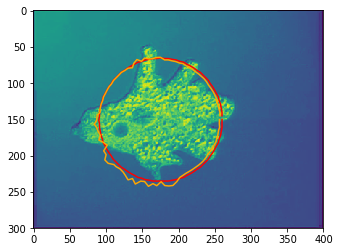

In [14]:
plt.plot(snake[:,0], snake[:,1], color = 'red')
plt.plot(snake[:,0]+displacement[:,0], snake[:,1]+displacement[:,1], color = 'orange')
plt.imshow(frames[0])
plt.show()

In [15]:
def extendedKernelSmothing(alpha, beta, N):
    Alph = np.zeros((N,N))
    Alph[1:, :-1] = Alph[1:, :-1] + np.identity(N-1)
    Alph[:-1, 1:] = Alph[:-1, 1:] + np.identity(N-1)
    Alph = Alph + (-2)*np.identity(N)
    Alph[0,N-1] = 1
    Alph[N-1,0] = 1
    Bet = np.zeros((N,N)) + (-6)*np.identity(N)
    Bet[2:,:-2] = Bet[2:,:-2] + (-1)*np.identity(N-2)
    Bet[:-2,2:] = Bet[:-2,2:] + (-1)*np.identity(N-2)
    Bet[1:,:-1] = Bet[1:,:-1] + 4*np.identity(N-1)
    Bet[:-1,1:] = Bet[:-1,1:] + 4*np.identity(N-1)
    Bet[0,N-2] = -1
    Bet[1,N-1] = -1
    Bet[N-2,0] = -1
    Bet[N-1,1] = -1
    Bet[N-1, 0] = 4
    Bet[0, N-1] = 4
    #print(Alph)
    #print(Bet)
    return(alpha*Alph + beta*Bet)

B_int = extendedKernelSmothing(alpha, beta, n)
snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake) # smooth snake as in the week 1 exercise.

## Run the displacement in a loop for initialisation:

In [16]:
# parameters
n=100
frames = np.zeros((478, 300, 400))
snake = np.zeros((n, 2))
x_0 = 175
y_0 = 150
r = 85
angle = 1/(n)
alpha = 1
beta = 0.1

# fill frames with grayscale frames
for i, frame in enumerate(mov):
    frames[i,:,:]=frame[:,:,0]/255.
    
# fill the snake for initialization:
for i, coord in enumerate(snake):
    coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
    snake[i] = coord
#snake[-1,:] = snake[0,:] #ensures closed curve


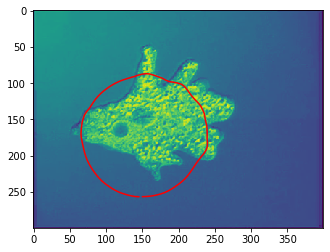

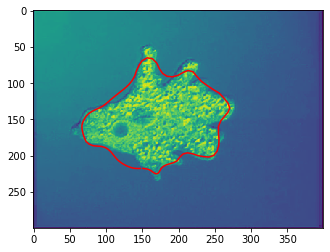

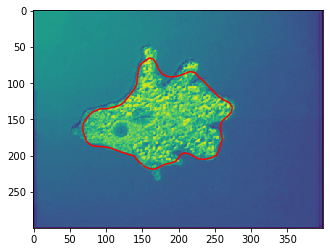

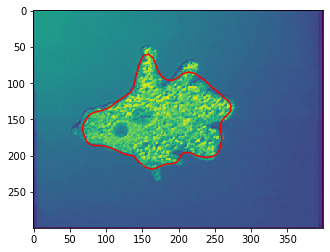

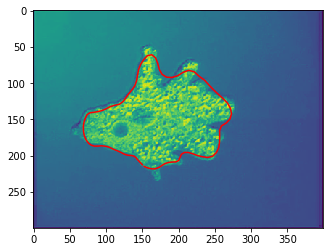

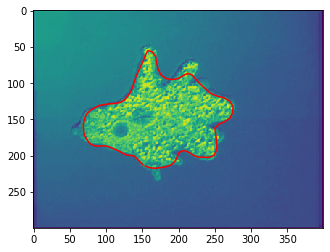

In [13]:
# Find intialization of snake

def updateSnake(snake, frame):
    mask = draw.polygon2mask(frame.shape, snake) # get inside/outside
    m_in, m_out, c_in, c_out = m1m2(frame, snake, mask) # get averages inside/outside
    z = forceImage_ext(frame, snake, m_in, m_out) # get values of force on curve
    N = snakeNormals(snake)
    
    displacement = 10*np.array([N[i]*z[i] for i in range(n)])
    snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake + displacement)
    return snake_smooth


# Intitialize snake:
for i in range(60):
    snake = updateSnake(snake, frames[0])
    if i%10==0:
        plt.plot(snake[:,1], snake[:,0], color = 'red')
        #plt.plot(snake[:,1]+displacement[:,1], snake[:,0]+displacement[:,0], color = 'orange')
        plt.imshow(frames[0])
        plt.show()

In [14]:
from snake_functions import *
#import snake_functions

In [19]:
%matplotlib tk
initSnake = snake
fig, ax = plt.subplots(1,1)

for frame in frames:
    # update snake for frame:
    for i in range(10):
        initSnake = updateSnake(initSnake, frame)
        initSnake = np.transpose(remove_intersections(initSnake))
    ax.cla()
    ax.imshow(frame)
    ax.plot(initSnake[:,1], initSnake[:,0], color = 'red')
    plt.pause(0.01)

In [20]:
plt.close()

In [ ]:
snake[:,0].shape